<a href="https://colab.research.google.com/github/BrunoVarg/AdventuresOfPikachu/blob/main/Cedulas_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train Detectron2 on Custom Objects

This tutorial implements the new [Detectron2 Library](https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/) by facebook. This notebook shows training on **your own custom objects** for object detection.

It is worth noting that the Detectron2 library goes far beyond object detection, supporting semantic segmentation, keypoint detection, mask, and densepose.


### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train Detectron2](https://blog.roboflow.ai/how-to-train-detectron2/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train Detectron2 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install Detectron2 dependencies
* Download custom Detectron2 object detection data
* Visualize Detectron2 training data
* Write our Detectron2 Training configuration
* Run Detectron2 training
* Evaluate Detectron2 performance
* Run Detectron2 inference on test images



### **About**

[Roboflow](https://roboflow.ai) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)

# Install Detectron2 Dependencies

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 22 kB/s 
     |████████████████████████████████| 6.6 MB 20.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.5.0+cu101

In [2]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 1.8 MB/s 
     |████████████████████████████████| 50 kB 2.8 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=c78a07b11eeb839231fec72866e845a724a55f18f5938a3e884374fd4f487237
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
Successfully built fvcore


In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Import and Register Custom Detectron2 Data

In [4]:
!curl -L "https://app.roboflow.com/ds/aVHtWr2M5n?key=Dn8hvcVTQf" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   884  100   884    0     0   2177      0 --:--:-- --:--:-- --:--:--  2177
100 12.7M  100 12.7M    0     0  15.2M      0 --:--:-- --:--:-- --:--:--  295M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/10-200_jpg.rf.2046a365d993d059e53f4832c62afbc6.jpg  
 extracting: test/11-100_jpg.rf.8a13dbf3247ea3d21d3ce370e83a0ce7.jpg  
 extracting: test/20220609_151942_jpg.rf.2386d59ddfc9dff923d557addd764bd7.jpg  
 extracting: test/20220622_145046_jpg.rf.09b1037e36a598ccc82eeb4ff61c983c.jpg  
 extracting: test/20220622_150139_jpg.rf.d8c6e1e3efaf0eb2d95115d622813072.jpg  
 extracting: test/44-100_jpg.rf.6a3cf181772b625d93d90b495fd9575c.jpg  
 extracting: test/450xN_jpg.rf.f2ab53213ec1010b3e9765fc0c27a157.jpg  
 extracting: test/58-200_jpg.rf.7721f710da9

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [07/06 13:22:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/06 13:22:00 d2.data.datasets.coco]: Loaded 486 images in COCO format from /content/train/_annotations.coco.json


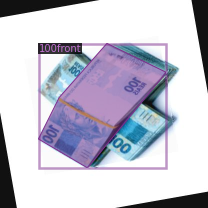

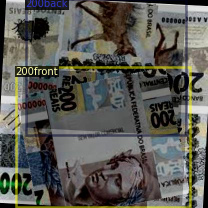

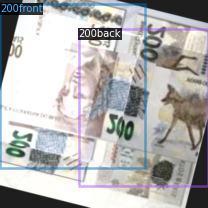

In [6]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

In [7]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [8]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/06 13:22:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:08, 52.5MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[07/06 13:22:22 d2.engine.train_loop]: Starting training from iteration 0
[07/06 13:22:59 d2.utils.events]:  eta: 0:46:00  iter: 19  total_loss: 2.119  loss_cls: 1.756  loss_box_reg: 0.360  loss_rpn_cls: 0.005  loss_rpn_loc: 0.012  time: 1.8512  data_time: 0.0271  lr: 0.000020  max_mem: 7238M
[07/06 13:23:38 d2.utils.events]:  eta: 0:47:09  iter: 39  total_loss: 1.745  loss_cls: 1.324  loss_box_reg: 0.296  loss_rpn_cls: 0.005  loss_rpn_loc: 0.011  time: 1.9205  data_time: 0.0122  lr: 0.000040  max_mem: 7238M
[07/06 13:24:20 d2.utils.events]:  eta: 0:47:51  iter: 59  total_loss: 1.248  loss_cls: 0.795  loss_box_reg: 0.318  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 1.9749  data_time: 0.0128  lr: 0.000060  max_mem: 7238M
[07/06 13:25:00 d2.utils.events]:  eta: 0:47:21  iter: 79  total_loss: 1.086  loss_cls: 0.608  loss_box_reg: 0.431  loss_rpn_cls: 0.004  loss_rpn_loc: 0.011  time: 1.9819  data_time: 0.0096  lr: 0.000080  max_mem: 7238M
[07/06 13:25:40 d2.utils.events]:  eta: 0:46:4

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [9]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [07/06 14:13:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/06 14:13:31 d2.data.datasets.coco]: Loaded 18 images in COCO format from /content/test/_annotations.coco.json
[07/06 14:13:31 d2.data.build]: Distribution of instances among all 7 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   money    | 0            |  100back   | 3            |  100front  | 2            |
|  200back   | 4            |  200front  | 3            |   50back   | 2            |
|  50front   | 7            |            |              |            |              |
|   total    | 21           |            |              |            |              |
[07/06 14:13:31 d2.data.common]: Serializing 18 elements to byte tensors and concatenating them all ...
[07/06 14:13:31 d2.data.common]: Serialized da

OrderedDict([('bbox',
              {'AP': 30.73373408769448,
               'AP-100back': 60.28288543140029,
               'AP-100front': 75.04950495049505,
               'AP-200back': 49.07001414427157,
               'AP-200front': 0.0,
               'AP-50back': 0.0,
               'AP-50front': 0.0,
               'AP-money': nan,
               'AP50': 43.994578029231505,
               'AP75': 37.9066478076379,
               'APl': 30.73373408769448,
               'APm': nan,
               'APs': nan})])

# Inference with Detectron2 Saved Weights



In [ ]:
%ls ./output/

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_train")

In [11]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install opencv-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,720 kB/s)
debconf: unable to initi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from distutils.sysconfig import customize_compiler
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import os
import math
import pytesseract

In [ ]:
# Faz o tratamento da imagem para tentar separar melhor o fundo da cedula

def adjust_background(img):
    # Processa a imagem

    # Dilata a imagem para se livrar do texto
    dilated_img = cv2.dilate(img, np.ones((7,7), np.uint8)) 
    # Borra a imagem para tentar apagar o texto
    bg_img = cv2.medianBlur(dilated_img, 21)
    # Calcula a diferença entre o original e o fundo que fizemos e invertemos o resultado
    diff_img = 255 - cv2.absdiff(img, bg_img)
    # Normaliza a imagem
    norm_img = diff_img.copy() # Needed for 3.x compatibility
    cv2.normalize(diff_img, norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

    # Normaliza mais para deixar a imagem menos cinza
    _, thr_img = cv2.threshold(norm_img, 230, 0, cv2.THRESH_TRUNC)
    cv2.normalize(thr_img, thr_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    return thr_img

In [14]:
# Le o numero de serie da cedula
def read_text_img():
    for root, dirs, files in os.walk("./images_serie"):
        for name in files:
            print(f'ARQUIVO : {name}')
            FS = os.path.sep
            print(pytesseract.image_to_string(root + FS + name))

In [15]:
# Acha os retangulos para análise de acordo com a nota

def nota_100_back(img, idx):
    altura, largura = img.shape[:2]

    w_i = int(0)
    h_i = int(altura*0.8584)
    w_f = int(largura*0.2665)
    h_f = int(altura)

    start_rec = (w_i, h_i)
    end_rec = (w_f, h_f)

    crop_img = img[h_i:h_f, w_i:w_f]
    gray=cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    # img_adjust = adjust_background(gray)
    cv2.imwrite(f'./images_serie/{idx}.jpg', gray) 

In [16]:
# Acha os retângulos para análise de acordo com a nota

def nota_100_front(img, index):

    copy_img = img
    altura, largura = copy_img.shape[:2]
    # Acha os retangulos
    color = (0, 0, 255)
    thickness = 2
    # Retangulo superior direito

    ww = int(largura*0.73)
    hh = int(altura*0.33)
    start_rec = (ww, 0)
    end_rec = (largura, hh)
    # print(f'({largura},{altura})')
    imgRec1 = cv2.rectangle(copy_img, start_rec, end_rec, color, thickness)
    # cv2.imwrite(f'./images_result/Rectangle_{index}_1.jpg', imgRec1) 

    w_i = int(largura*0.41)
    h_i = int(altura*0.43)
    w_f = int(largura*0.60)
    h_f = int(altura*0.78)

    start_rec = (w_i, h_i)
    end_rec = (w_f, h_f)

    imgRec2 = cv2.rectangle(imgRec1, start_rec, end_rec, color, thickness)

    w_i = int(largura * 0.7597)
    h_i = int(altura * 0.3376)
    w_f = int(largura * 0.9714)
    h_f = int(altura * 0.6926)

    start_rec = (w_i, h_i)
    end_rec = (w_f, h_f)

    imgRec3 = cv2.rectangle(imgRec2, start_rec, end_rec, color, thickness)

    cv2.imwrite(f'./images_rectangle/Rectangles_{index}.png', imgRec3)


In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob
import json

f = open('./train/_annotations.coco.json')
data = json.load(f)

idx = 0
for imageName in glob.glob('/content/images/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  pred_class = outputs["instances"].pred_classes[0].item()
  name_class = data["categories"][pred_class]["name"]
  print(name_class)
  altura, largura = im.shape[:2]

  # Rotaciona 90 graus
  if altura>largura:
      im = cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
  

  image_adjust = adjust_background(im)
  #cv2.imwrite(f'./images_test/{idx+1}.png', image_adjust)

  # Transforma imagem em escala de cinza
  gray = cv2.cvtColor(image_adjust, cv2.COLOR_BGR2GRAY)

  # Acha todos os contornos da imagem, especificando a precisao
  edged = cv2.Canny(gray, 0, 1500, apertureSize=5) 
  #cv2.imwrite('./images_edge/' + str(idx+1) + '.png', edged)

  # Retorna os contornos em  um quadrado x,y
  (cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
  #print(cnts)
  menorx, menory, maiorxw, maioryh = [100000000, 100000000, 0, 0]

  # Percorre todos os contornos
  idxa = 0
  for c in cnts: 
      x, y, w, h = cv2.boundingRect(c) 
      
      if w>50 and h>50:   
          # salva os pontos extremos
          menorx = min(x, menorx)
          menory = min(y, menory)
          maiorxw = max(x+w, maiorxw)
          maioryh = max(y+h, maioryh)
          idxa+=1 
          # new_img = im[y:y+h,x:x+w] 

  crop_img = im[menory:maioryh, menorx:maiorxw]
  # cv2.imwrite(f'./images_cut/{idx}.jpg', crop_img) 

  altura, largura = crop_img.shape[:2]

  if name_class == '100back':
    nota_100_back(crop_img, idx)
  elif name_class == '100front':
    nota_100_front(crop_img, idx)
  # print(outputs["instances"].pred_classes[0].item())
  # print(outputs["instances"].pred_boxes)

  if outputs["instances"].pred_classes.size() == torch.Size([0]):
      # cv2_imshow(im)
      continue

  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

  idx += 1


100back


In [18]:
read_text_img()

ARQUIVO : 12.jpg
—. REAIS «

ARQUIVO : 6.jpg
AAUVUUUUUUUU

ARQUIVO : 0.jpg
‘CC 135792468

ARQUIVO : 17.jpg
PK 046297247.

eee eR Ee eel

ARQUIVO : 19.jpg
* ORESORMTEDSO ecies Si i 6 te %
ROEM,

9 E01475911:

ARQUIVO : 16.jpg
 

ARQUIVO : 11.jpg
a
Aare

Le

 

ARQUIVO : 18.jpg
 

ei7- REAIS

ARQUIVO : 10.jpg
 

ARQUIVO : 9.jpg
 

ARQUIVO : 8.jpg
PK 046297247

ARQUIVO : 21.jpg

ARQUIVO : 20.jpg
 

ARQUIVO : 2.jpg
‘CC 135792468

ARQUIVO : 7.jpg

ARQUIVO : 4.jpg
‘CC 135792468



In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
